In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pickle
from utils import get_best_t
from utils import get_theory_curves

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font = {'family' : 'Arial',
    'weight' : 'medium',
    'size'   : 14,
    'style'  : 'normal'}
matplotlib.rc('font', **font)

In [2]:
T_values = np.arange(100, 301, 10)
v0_values = [0.0001, 0.2, 0.4, 0.6, 0.8, 1, 1.5, 2, 2.5, 3, 3.5,
             4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.6,
             10, 10.5, 11, 11.5, 12, 12.5, 13, 14, 15]

In [3]:
# Get theoretical positions and depths of log-derivative minima
# across a grid of loop periods T and effective fragment lengths v0

theory_xmins, theory_ymins, s_grid, v0_values = get_theory_curves()

In [4]:
# helper functions

def load_logder_pair(y_name, x_name):
    """Load (mids, slope) from pickle files."""
    with open(f"{data_dir}/{y_name}", "rb") as f:
        slope = pickle.load(f)
    with open(f"{data_dir}/{x_name}", "rb") as f:
        mids = pickle.load(f)
    return np.asarray(mids), np.asarray(slope)


def find_minimum(mids, slope, window=20):
    """
    Find (x, y) of the local minimum within the first `window` points.
    mids is assumed to be 1D, slope is d log P / d log s.
    """
    # use mids[1:] in plotting, but minima are taken from slope[0:window]
    y_min = np.min(slope[:window])
    x_min = mids[1 + np.argmin(slope[:window])]
    return x_min, y_min


def theory_logder(s, T_kb, v0_kb, smooth_sigma=0.1):
    """
    Compute theoretical log-derivative for given T, v0 at separations s (kb).
    Uses Eq. (3) with optional Gaussian smoothing.
    """
    gamma = 2.0 * s / (3.0 * v0_kb)
    y = (
        3.0 * s * gamma * (gamma + 2.0) / (T_kb * 2.0 * (gamma + 1.0) ** 2)
        - 3.0 * gamma / (2.0 * (gamma + 1.0))
    )
    if smooth_sigma is not None and smooth_sigma > 0:
        y = gaussian_filter1d(y, smooth_sigma)
    return y

FA & DpnII
y-minimum =  -0.719940687740236
x-minimum =  27.92848008753788
Inferred T  =  130
Inferred v0 =  9.0
MSE         =  1.8926867088701697e-05

FA+DSG, DpnII
y-minimum =  -0.9657564409334154
x-minimum =  16.97056274847714
Inferred T  =  110
Inferred v0 =  3.0
MSE         =  2.7456743607728327e-05



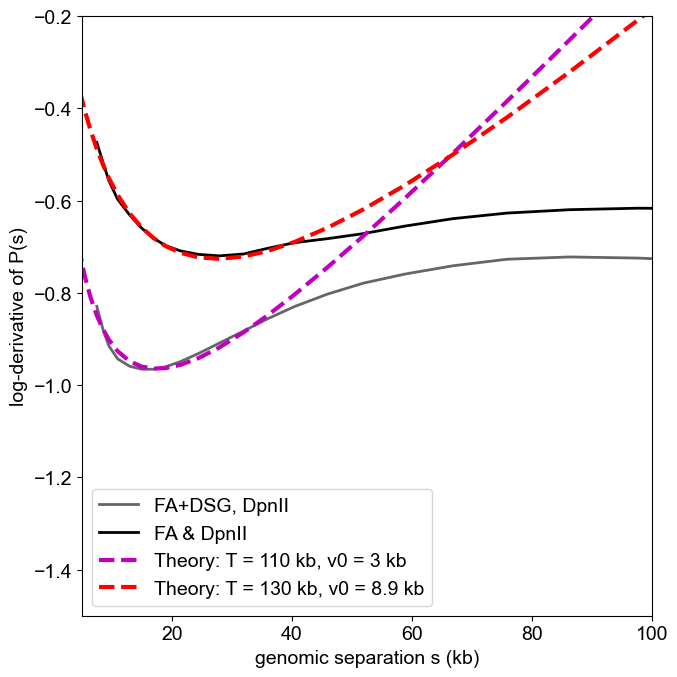

In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots(figsize=(7, 7))

#data_dir = "logders_fig4"
data_dir = "../data/data_fig4"


# --- Load experimental curves ---

mids_fa_dsg, slope_fa_dsg = load_logder_pair(
    "full_logder_y_oksuz_esc_U54-ESC4DN-DSG-DpnII-R1-R2_hg38.mapq_30.1000.mcool.pickle",
    "full_logder_x_oksuz_esc_U54-ESC4DN-DSG-DpnII-R1-R2_hg38.mapq_30.1000.mcool.pickle",
)

mids_fa, slope_fa = load_logder_pair(
    "full_logder_y_oksuz_esc_U54-ESC4DN-FA-DpnII-R1-R2_hg38.mapq_30.1000.mcool.pickle",
    "full_logder_x_oksuz_esc_U54-ESC4DN-FA-DpnII-R1-R2_hg38.mapq_30.1000.mcool.pickle",
)


# --- Plot experimental curves ---

ax.plot(mids_fa_dsg[1:], slope_fa_dsg, color="k", alpha = 0.6, linewidth=2, label="FA+DSG, DpnII")
ax.plot(mids_fa[1:], slope_fa, color="k", alpha=1, linewidth=2, label="FA & DpnII")

# --- Find minima and infer parameters ---

for label, mids, slope in [
    ("FA & DpnII", mids_fa, slope_fa),
    ("FA+DSG, DpnII", mids_fa_dsg, slope_fa_dsg)
]:
    print(label)
    x_min, y_min = find_minimum(mids, slope, window=20)
    print("y-minimum = ", y_min)
    print("x-minimum = ", x_min)

    t, v0, err = get_best_t(
        (x_min, y_min),
        theory_xmins=theory_xmins,
        theory_ymins=theory_ymins,
        T_values=T_values,
        v0_values=v0_values,
        x_weight=1e-4,
    )
    print("Inferred T  = ", t)
    print("Inferred v0 = ", v0)
    print("MSE         = ", err)
    print()


# --- Plot theory curves for illustrative T values (fixed v0) ---

for T_kb, v0, color, label in [
    (110, 3, "m", "Theory: T = 110 kb, v0 = 3 kb"),
    (130, 8.9, "r", "Theory: T = 130 kb, v0 = 8.9 kb")
]:
    der = theory_logder(mids_fa[1:], T_kb=T_kb, v0_kb=v0, smooth_sigma=0)
    ax.plot(
        mids_fa[1:],
        der,
        color=color,
        linewidth=3,
        linestyle="--",
        label=label,
    )

# --- Axes & aesthetics ---

ax.set_ylim([-1.5, -0.2])
ax.set_xlim([5, 100])

ax.set_xlabel("genomic separation s (kb)")
ax.set_ylabel("log-derivative of P(s)")

ax.legend()
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
